## 1. Setup and Imports

In [18]:
import pandas as pd
import numpy as np
import spacy
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
import spacy

# Load the spacy model (downloading it if necessary)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading 'en_core_web_sm' model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")


def preprocess_text(text):
    if not isinstance(text, str):
        return ""
 
    doc = nlp(text.lower())
    
    tokens = [
        token.lemma_ for token in doc 
        if not token.is_stop 
        and not token.is_punct 
        and token.is_alpha 
        and len(token.text) > 2
    ]
    
    return ' '.join(tokens)


## 2. Load and Explore Dataset

In [ ]:
df = pd.read_csv("fake_reviews_dataset.csv")

df = df[["category", "text_"]]
df.dropna(inplace=True)

df["clean_text"] = df["text_"].apply(preprocess_text)

## 4. Feature Engineering with TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df["clean_text"]).toarray()


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["category"])

num_classes = len(label_encoder.classes_)
print("Number of categories:", num_classes)


Number of categories: 10


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)


In [ ]:
class ProductCategoryClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x


In [ ]:
model = ProductCategoryClassifier(
    input_dim=X_train.shape[1],
    num_classes=num_classes
)

criterion = nn.CrossEntropyLoss()   # Correct for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 35
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    outputs = model(X_train)
    
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    preds = torch.argmax(outputs, dim=1)
    acc = accuracy_score(y_train, preds)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")


Epoch [1/35] | Loss: 2.3082 | Accuracy: 0.1081
Epoch [2/35] | Loss: 2.3066 | Accuracy: 0.1081
Epoch [3/35] | Loss: 2.3050 | Accuracy: 0.1081
Epoch [4/35] | Loss: 2.3032 | Accuracy: 0.1081
Epoch [5/35] | Loss: 2.3012 | Accuracy: 0.1081
Epoch [6/35] | Loss: 2.2990 | Accuracy: 0.1081
Epoch [7/35] | Loss: 2.2966 | Accuracy: 0.1081
Epoch [8/35] | Loss: 2.2941 | Accuracy: 0.1089
Epoch [9/35] | Loss: 2.2914 | Accuracy: 0.1145
Epoch [10/35] | Loss: 2.2887 | Accuracy: 0.1280
Epoch [11/35] | Loss: 2.2859 | Accuracy: 0.1469
Epoch [12/35] | Loss: 2.2829 | Accuracy: 0.1681
Epoch [13/35] | Loss: 2.2799 | Accuracy: 0.1893
Epoch [14/35] | Loss: 2.2767 | Accuracy: 0.2059
Epoch [15/35] | Loss: 2.2735 | Accuracy: 0.2283
Epoch [16/35] | Loss: 2.2700 | Accuracy: 0.2525
Epoch [17/35] | Loss: 2.2665 | Accuracy: 0.2755
Epoch [18/35] | Loss: 2.2628 | Accuracy: 0.2987
Epoch [19/35] | Loss: 2.2589 | Accuracy: 0.3175
Epoch [20/35] | Loss: 2.2549 | Accuracy: 0.3291
Epoch [21/35] | Loss: 2.2507 | Accuracy: 0.3388
E

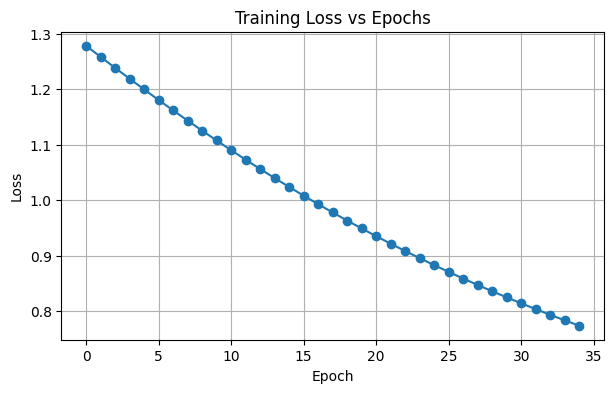

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()


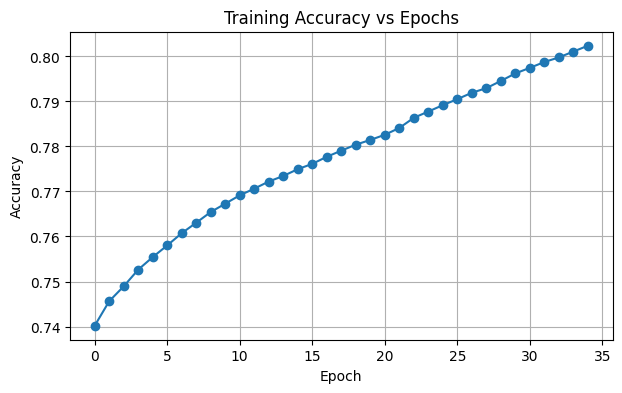

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(train_accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Epochs")
plt.grid(True)
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = torch.argmax(test_outputs, dim=1)


In [ ]:
print(
    classification_report(
        y_test,
        test_preds,
        target_names=label_encoder.classes_
    )
)


                              precision    recall  f1-score   support

                     Books_5       0.71      0.66      0.68       874
Clothing_Shoes_and_Jewelry_5       0.75      0.81      0.78       770
               Electronics_5       0.77      0.80      0.79       798
          Home_and_Kitchen_5       0.67      0.68      0.68       811
              Kindle_Store_5       0.71      0.77      0.74       946
             Movies_and_TV_5       0.91      0.83      0.87       717
              Pet_Supplies_5       0.80      0.83      0.82       851
       Sports_and_Outdoors_5       0.58      0.48      0.53       789
Tools_and_Home_Improvement_5       0.65      0.65      0.65       772
            Toys_and_Games_5       0.76      0.81      0.78       759

                    accuracy                           0.73      8087
                   macro avg       0.73      0.73      0.73      8087
                weighted avg       0.73      0.73      0.73      8087



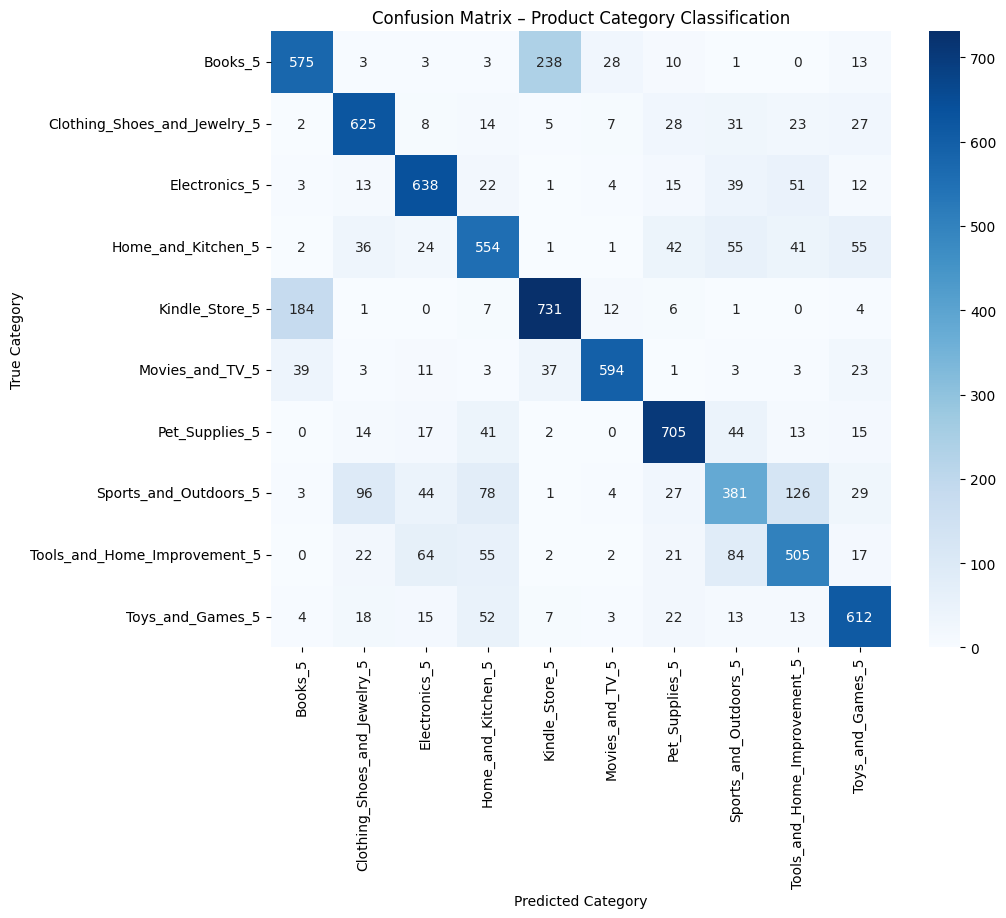

In [ ]:
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Confusion Matrix – Product Category Classification")
plt.show()
